In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [2]:
def time_converter(data, minute=False):
    x = data.split('-')
    if len(x)==1:
        d = 0
        x = x[0]
    else:
        d = int(x[0])
        x = x[1]
    h,m,s = map(int,x.split(':'))
    if minute == True:
        return (d*24 + h)*60 + m + s/60
    return ((d*24 + h)*60+m)*60+s

In [3]:
df = pd.read_excel('xnat_accre_full_stats.xlsx')

In [4]:
df.head()

,jobstartdate,jobSubmitDate,id,proctype,memused,input(MB),output(MB),walltime(min),JobID,Submit,...,ExitCode,State,NNodes,NCPUS,ReqCPUS,ReqMem,ReqGRES,ReqTRES,Timelimit,NodeList
0,2018-01-01,2017-12-22,VUIISXNAT02_E226662,MaCRUISE_Parcel_v2,4631908,7.0,253.0,408.316667,23101185,2018-01-01T15:01:37,...,00:00:00,COMPLETED,1,1,1,16000Mn,NaN,"cpu=1,mem=16000M,node=1",12:00:00,vmp1044
1,2018-01-01,2017-12-22,VUIISXNAT02_E226752,MaCRUISE_Parcel_v2,4212364,5.9,198.0,238.000000,23101253,2018-01-01T16:01:34,...,00:00:00,COMPLETED,1,1,1,16000Mn,NaN,"cpu=1,mem=16000M,node=1",12:00:00,vmp201
2,2018-01-01,2017-12-22,VUIISXNAT02_E226788,MaCRUISE_Parcel_v2,4146228,5.4,198.0,236.700000,23101254,2018-01-01T16:01:34,...,00:00:00,COMPLETED,1,1,1,16000Mn,NaN,"cpu=1,mem=16000M,node=1",12:00:00,vmp202
3,2018-01-01,2017-12-22,VUIISXNAT02_E226806,MaCRUISE_Parcel_v2,4432564,7.6,220.0,287.683333,23101255,2018-01-01T16:01:34,...,00:00:00,COMPLETED,1,1,1,16000Mn,NaN,"cpu=1,mem=16000M,node=1",12:00:00,vmp205
4,2018-01-01,2017-12-22,VUIISXNAT02_E226824,MaCRUISE_Parcel_v2,3963128,6.6,158.0,154.983333,23101252,2018-01-01T16:01:34,...,00:00:00,COMPLETED,1,1,1,16000Mn,NaN,"cpu=1,mem=16000M,node=1",12:00:00,vmp211


In [5]:
df['ReqMem_num'] = pd.to_numeric(df['ReqMem'].map(lambda x: x.rstrip('MnG')))

In [6]:
df['Timelimit_num'] = df['Timelimit'].astype(str)
df['Timelimit_num'] = df.Timelimit_num.apply(time_converter)

In [24]:
df[df.proctype == "dtiQA_v6"][["ReqMem_num", "Timelimit_num"]].drop_duplicates()

,ReqMem_num,Timelimit_num
104,10000,36000
3671,20000,345600
5144,40000,345600


In [15]:
mem_prop = {}
mem_prop["dtiQA_v6"] = False
mem_prop["fMRI_Connectivity_PreProcess_Scan_v2"] = False # in MB not GB

### Read the timeout log and plot timeout runs compared to application behavior

In [16]:
dataset = "dtiQA_v6"

In [25]:
request = df[df.proctype == "dtiQA_v6"][["ReqMem_num", "Timelimit_num"]].drop_duplicates()
df[df.proctype == dataset].head()

,ReqMem_num,Timelimit_num
104,10000,36000
3671,20000,345600
5144,40000,345600


In [36]:
dfset = df[df.proctype == dataset]
dfset = dfset[dfset['memused'].notnull()].copy()
dfset['memused'] = dfset['memused'].astype(str)
dfset = dfset[dfset.memused.apply(lambda x: x.isnumeric())]

dfset['memused'] =  pd.to_numeric(dfset['memused']) / 1024

request["Timelimit_num"] = request["Timelimit_num"] / 60
if dataset not in mem_prop:
    request["ReqMem_num"] = request["ReqMem_num"] * 1024
request

,ReqMem_num,Timelimit_num
104,10000,600.0
3671,20000,5760.0
5144,40000,5760.0


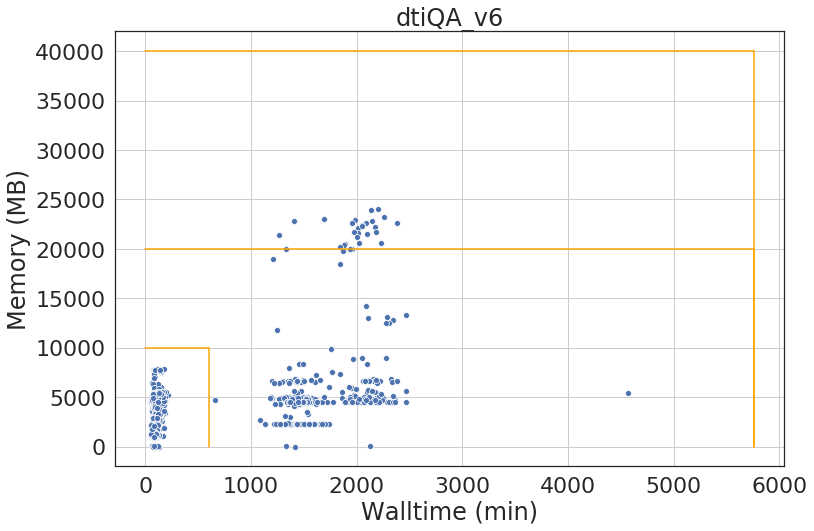

In [37]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
ax = sns.scatterplot(y="memused", x="walltime(min)",
                     data=dfset)

# set the request times
for i in request.values:
    # time in database is in min
    plt.plot([i[1], i[1]], [0, i[0]], color='orange')
    plt.plot([0, i[1]], [i[0], i[0]], color='orange')

plt.grid(True)
ax.set_xlabel('Walltime (min)')
ax.set_ylabel('Memory (MB)')
ax.set_title(dataset)

plt.savefig("figures/%s.png" %(dataset))
plt.show()